# 딥러닝으로 텍스트 데이터 다루기

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [2]:
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
texts[0:5]

["Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.",
 'Well...tremors I, the original started off in 1990 and i found the movie quite enjoyable to watch. however, they proceeded to make tremors II and III. Trust me, those movies started going downhill right after they finished the first one, i mean, ass blasters??? Now, only God himself is capable of answering the question "why in Gods name would they create another one of these dumpster dives of a movie?" Tremors IV cannot be considered a bad movie, in fact it cannot be even considered an epitome of a bad movie, for it lives up to more than that. As i attempted to sit though it, i noticed that my eyes started to bleed, and i hoped profusely that the little girl from the ring would crawl through the TV and kill me. did they really think 

### 데이터 토큰화

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [5]:
max_len = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [6]:
tokenizer = Tokenizer(num_words=max_words)    # 데이터셋에서 가장 빈도 높은 1만 개의 단어만 사용함
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [7]:
word_index = tokenizer.word_index
print(f'{len(word_index)}개의 고유한 토큰을 찾았습니다.')

88582개의 고유한 토큰을 찾았습니다.


In [8]:
data = pad_sequences(sequences, maxlen=max_len)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [9]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [10]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

### GloVe 임베딩

In [11]:
glove_dir = './datasets/glove.6B'

In [12]:
# 단어 임베딩 파일 파싱

embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(f'{len(embeddings_index)}개의 단어 벡터를 찾았습니다.')

400000개의 단어 벡터를 찾았습니다.


In [13]:
# Glove 단어 임베딩 행렬 준비
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector       # 임베딩 인덱스에 없는 단어는 모두 0이 되어야 함

### 모델 정의하기

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [15]:
model = Sequential()
model.add(Embedding(max_words, 100, input_length = max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 모델에 Glove 임베딩 로드하기

In [16]:
# 2D 부동 소수 행렬, 각 i번째 원소는 i번째 인덱스에 상응하는 단어 벡터
model.layers[0]

In [17]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# 이미 학습된 특성에 랜덤하게 초기화된 층에서 대량의 그래디언트 업데이트가 발생하면 
## 이미 학습된 특성을 오염시키기 때문에 False

### 모델 훈련 및 평가

In [18]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10, batch_size=32, validation_data=(x_val, y_val))


model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 1.0122 - acc: 0.5750 - val_loss: 0.6930 - val_acc: 0.5020
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.6531 - acc: 0.6100 - val_loss: 0.7079 - val_acc: 0.5017
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.6650 - acc: 0.5850 - val_loss: 0.6939 - val_acc: 0.5014
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.6304 - acc: 0.5450 - val_loss: 0.6920 - val_acc: 0.5028
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5729 - acc: 0.6250 - val_loss: 0.8208 - val_acc: 0.5011
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5397 - acc: 0.6500 - val_loss: 0.6873 - val_acc: 0.5508
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 0.4775 - acc: 0.7300 - val_loss: 0.6871 - val_acc: 0.5604
Epoch 8/10
200/200 [========

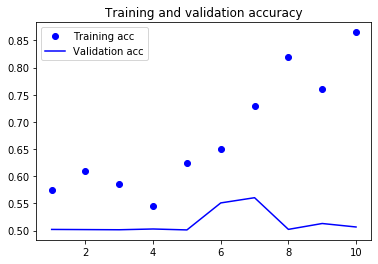

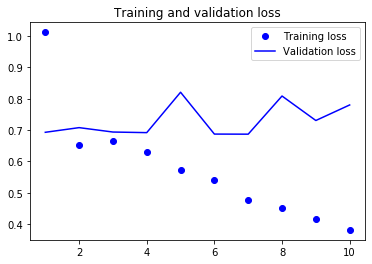

In [19]:
## 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 사전 훈련된 단어 임베딩을 사용하지 않고 모델 훈련

In [20]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

/Users/billy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6955 - acc: 0.4500 - val_loss: 0.6928 - val_acc: 0.5104
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5043 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.5215
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2733 - acc: 0.9850 - val_loss: 0.6953 - val_acc: 0.5254
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1178 - acc: 1.0000 - val_loss: 0.7017 - val_acc: 0.5233
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0565 - acc: 1.0000 - val_loss: 0.7007 - val_acc: 0.5329
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0287 - acc: 1.0000 - val_loss: 0.7049 - val_acc: 0.5325
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0160 - acc: 1.0000 - val_loss: 0.7095 - val_acc: 0.5350
Epoch 8/10
200/200 [========

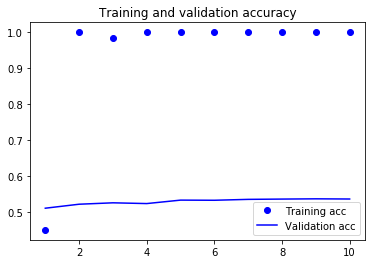

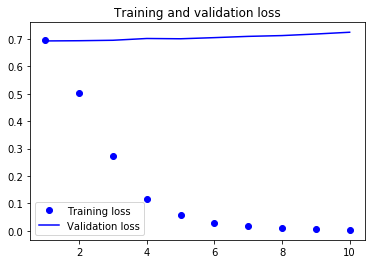

In [22]:
## 결과 그래프 그리기

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 훈련 샘플의 수 늘리기

### 테스트 데이터 토큰화하기

In [23]:
tokenizer = Tokenizer(num_words=10000)

In [24]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [25]:
# 첫 번째 모델을 로드하고 평가

In [28]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 0s 16us/step


[0.6934143900871277, 0.5]

# 순환 신경망(RNN) 이해하기

### 실습

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection  import train_test_split

In [ ]:
imdb_data = pd.read_csv('IMDB Dataset.csv')

# 감정 값 0, 1 숫자로 변형
imdb_data['sentiment'] = imdb_data['sentiment'].replace("positive", 1)
imdb_data['sentiment'] = imdb_data['sentiment'].replace("negative", 0)

In [ ]:
# 정규표현식으로 단어가 아니면 삭제

imdb_data['review'] = imdb_data['review'].str.replace("[^\w]|br", " ")

In [ ]:
# 혹시나 공백이 있다면 Null array로 바뀜

imdb_data['review'] = imdb_data['review'].replace('', np.nan)
imdb_data['sentiment'] = imdb_data['sentiment'].replace('', np.nan)

In [ ]:
# null array 모두 제거 (공백인 열 모두 제거)

imdb_data = imdb_data.dropna(how='any')

print(imdb_data)
print("# preprocessing done")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imdb_data['review'], imdb_data['sentiment'], random_state=0)

In [ ]:
stopwords = ['a', 'an']

x_train = []
for stc in X_train:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    x_train.append(token)
    
x_test = []
for stc in X_test:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    x_test.append(token)


In [ ]:
print(x_test[0])

## 각각 단어 마다 인덱스 부여 --- train_set을 기준으로 한다!!!

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# 전체 단어 갯수 설정 -> 유의미한 단어 갯수가 뭔지 우선 파악

tokenizer = Tokenizer(5000)   # 5천개 단어까지만 인덱스를 부여하라 / 단어의 개수를 세서..전체 인덱스
tokenizer.fit_on_texts(x_train)

In [ ]:
# 위에 정수 인덱스를 토대로 문장을 변환!
x_train = tokenizer.texts_to_sequences(x_train)     # 토큰나이징 된 것을 기준으로 문장 변환
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train[1])
print(y_train)

In [ ]:
# 문장 길이를 맞춰준다  (패딩)
## 임의로 맞추는게 아니라, 데이터셋을 보면서 최대 문장의 길이가 얼마인지 확인하고 거기에 맞춘다

max_len = 500
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [ ]:
len(x_train)

In [ ]:
# 모델 구축

model = Sequential()

model.add(Embedding(1000, 120))

## RNN / LSTM
model.add(LSTM(120))

## 긍정/부정을 판단 이진 분류 -> sigmoid 함수 사용
model.add(Dense(1, activation='sigmoid'))

In [ ]:
## 혹시 5회 이상 검증데이터 loss가 증가하면 , 과적할 될 수 있어 조기종료!
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)       ## 참을성은 5 압력되었습니다

# 훈련을 거듭하면서, 가장 검증데이터 정확도가 높았던 순간을 체크포인트로 저장
el_check = ModelCheckpoint('the_best.h5', monitor='val_acc', mode='max', verbose=1, )   ## verbose=1, save_best_only=True

In [ ]:
# 긍정/부정을 판단하는 손실함수, 이진 교차 엔트로피, 최적화, 평가 기준!  acc (출력할때 뜬다)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=64, callbacks=[early_stop, el_check])

In [ ]:
# 정학도 측정
print(model.evaluate(x_test, y_test))

# 실습 네이버 영화리뷰

In [ ]:
from konlpy.tag import Okt, Kkma
import pandas as pd

In [ ]:
data = pd.read_csv('ratings.txt', sep = '\t', quoting=3)

In [ ]:
data.info()

In [ ]:
# 문자가 아닌 단어 삭제

data['document'] = data['document'].str.replace("[^\w]|br", " ")

In [ ]:
data['document'] = data['document'].replace('', np.nan)   #결측치(공백)이 있다면 Na로 변환
data['label'] = data['label'].replace('', np.nan)

In [ ]:
## 공백인 열 '모두' 제거

data = data.dropna(how='any')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['document'], data['label'], test_size=0.4, shuffle=False, random_state=0)

# 스탑워즈 제거
stopwords = ['을', '를', '이', '가', '으로', '로', '에', '에서']

x_train = []
for stc in X_train:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    x_train.append(token)
    
x_test = []
for stc in X_test:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    x_test.append(token)

In [ ]:
print(x_test[0])

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# 정수 인덱스 부여

tokenizer = Tokenizer(20000)       # 원래 단어 개수가 40000개 정도 된다
tokenizer.fit_on_texts(x_train)

In [ ]:
## (중요) 위에 정수 인덱스를 토대로 문장을 변환!
x_train = tokenizer.texts_to_sequences(x_train)     # 토큰나이징 된 것을 기준으로 문장 변환
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
## len(x_train).max()

In [ ]:
# 패딩 최대 길이에 맞춘다

max_len = 50
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [ ]:
# 모델 구축

model = Sequential()

model.add(Embedding(20000, 120))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))

## 혹시 5회 이상 검증데이터 loss가 증가하면 , 과적할 될 수 있어 조기종료!
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)       ## 참을성은 5 압력되었습니다
el_check = ModelCheckpoint('the_best.h5', monitor='val_acc', mode='max', verbose=1, )   ## verbose=1, save_best_only=True

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=1, batch_size=64)

In [ ]:
#model.predict(['우리는 대한민국 사람입니다'])

## 넘파이로 구현한 간간한 RNN

In [5]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

# 입력 데이터 : 예제를 위해 생성한 난수
inputs = np.random.random((timesteps, input_features,))   

# 초기 상태: 모두 0인 벡터
state_t = np.zeros((output_features, ))


In [6]:
# 무작위 가중치 행렬 생성

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

In [7]:
# 입력과 현재 상태(이전 출력)를 연결하여 현재 출력을 얻는다

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    successive_outputs.append(output_t)
    
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)

In [8]:
input_features

32

In [10]:
output_features

64

In [15]:
np.array(successive_outputs).shape

(100, 64)

In [9]:
output_t

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
state_t

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [17]:
final_output_sequence

array([[0.99999989, 0.99999995, 0.99999967, ..., 0.99999987, 1.        ,
        0.99999982],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [18]:
final_output_sequence.shape

(100, 64)

In [20]:
## IMDB 영화 리뷰 분류 문제

In [22]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [24]:
max_features = 10000
max_len = 500
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')

input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_test = sequence.pad_sequences(input_test, maxlen=max_len)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
17465344/17464789 [==============================] - 4s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


In [27]:
## 모델 훈련
from keras.layers import Dense
from keras.models import Sequential
# from keras.preprocessing.text import Embedding  -> 전처리 : 토크나이저
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

In [28]:
history = model.fit(input_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

/Users/billy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 16s 813us/step - loss: 0.5413 - acc: 0.7197 - val_loss: 0.4157 - val_acc: 0.8228
Epoch 2/10
20000/20000 [==============================] - 16s 811us/step - loss: 0.3860 - acc: 0.8385 - val_loss: 0.4063 - val_acc: 0.8216
Epoch 3/10
20000/20000 [==============================] - 16s 815us/step - loss: 0.2585 - acc: 0.9022 - val_loss: 0.3957 - val_acc: 0.8442
Epoch 4/10
20000/20000 [==============================] - 16s 819us/step - loss: 0.2056 - acc: 0.9226 - val_loss: 0.3826 - val_acc: 0.8438
Epoch 5/10
20000/20000 [==============================] - 17s 828us/step - loss: 0.1208 - acc: 0.9609 - val_loss: 0.4593 - val_acc: 0.8078
Epoch 6/10
20000/20000 [==============================] - 17s 839us/step - loss: 0.0683 - acc: 0.9805 - val_loss: 0.4825 - val_acc: 0.8438
Epoch 7/10
20000/20000 [==============================] - 17s 844us/step - loss: 0.0370 - acc: 0.9912 - val_loss: 0.5

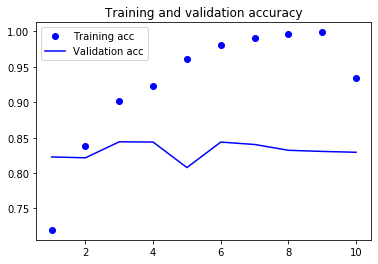

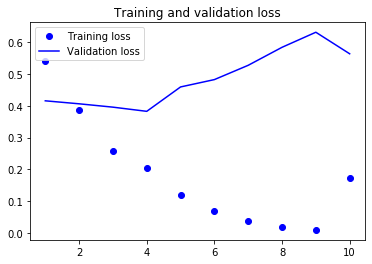

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss =history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# LSTM 층 사용하기

In [31]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

/Users/billy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.5011 - acc: 0.7583 - val_loss: 0.3365 - val_acc: 0.8612
Epoch 2/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.2915 - acc: 0.8857 - val_loss: 0.2824 - val_acc: 0.8872
Epoch 3/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.2341 - acc: 0.9120 - val_loss: 0.2917 - val_acc: 0.8874
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.2020 - acc: 0.9240 - val_loss: 0.2909 - val_acc: 0.8776
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1831 - acc: 0.9342 - val_loss: 0.3633 - val_acc: 0.8490
Epoch 6/10
20000/20000 [==============================] - 30s 1ms/step - loss: 0.1608 - acc: 0.9426 - val_loss: 0.3160 - val_acc: 0.8874
Epoch 7/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.1435 - acc: 0.9494 - val_loss: 0.5484 - val_acc:

### LSTM 텍스트 이외 적용

In [49]:
import os
data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [50]:
with open(fname) as f:
    data = f.read()

In [51]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [52]:
## 데이터 파싱
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

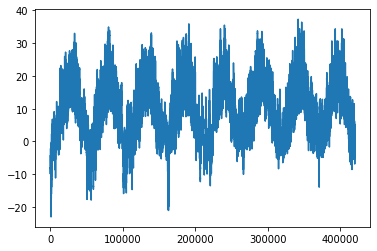

In [53]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

In [54]:
## 그래프에서 일별 주기성을 볼 수 있다

#### 데이터 준비

- lookback : 타임스텝만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링
- step = 6 : 1시간마다 데이터 포인트 하나를 샘플링
- delay = 144 : 24시간이 지난 데이터가 타깃

In [55]:
# 시계열 데이터와 타깃을 반환하는 제너레이터 함수

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### 훈련, 검증, 테스트 제너레이터 준비하기

In [56]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [57]:
## 상식적인 기준 모델의 MAE 계산

def evaluate_naive_method():
    batch_maes = []
    
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

2.5669342287061117


# 딥러닝 LSTM 모델 학습 

In [58]:
# 완전 연결 모델

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import RMSprop

In [59]:
model = Sequential()
model.add(Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 9s 19ms/step - loss: 23.7588 - val_loss: 10.0153
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 10.0869 - val_loss: 9.2918
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 9.8099 - val_loss: 8.9610
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 9.5078 - val_loss: 10.3155
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 9.2063 - val_loss: 8.9667
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 8.9591 - val_loss: 8.2740
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 8.6741 - val_loss: 9.4419
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 8.4762 - val_loss: 8.0070
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 8.2551 - val_loss: 8.0697
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 8.0489

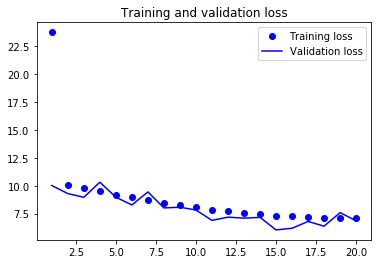

In [63]:
# 결과 그래프
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 순환 신경망(RNN) 

In [68]:
from keras.layers import GRU

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500, epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 69s 139ms/step - loss: 7.7714 - val_loss: 6.5046
Epoch 2/20
500/500 [==============================] - 68s 136ms/step - loss: 6.4942 - val_loss: 5.6167
Epoch 3/20
500/500 [==============================] - 68s 136ms/step - loss: 6.1306 - val_loss: 5.8772
Epoch 4/20
500/500 [==============================] - 68s 135ms/step - loss: 5.8140 - val_loss: 5.4048
Epoch 5/20
500/500 [==============================] - 68s 136ms/step - loss: 5.5274 - val_loss: 4.7698
Epoch 6/20
500/500 [==============================] - 69s 138ms/step - loss: 5.2353 - val_loss: 5.1680
Epoch 7/20
500/500 [==============================] - 69s 138ms/step - loss: 4.9832 - val_loss: 4.6952
Epoch 8/20
500/500 [==============================] - 69s 137ms/step - loss: 4.8218 - val_loss: 4.6342
Epoch 9/20
500/500 [==============================] - 68s 137ms/step - loss: 4.6373 - val_loss: 3.7269
Epoch 10/20
500/500 [==============================] - 71s 141ms/step - l

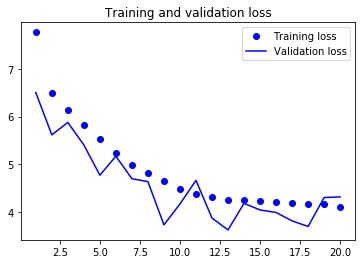

In [70]:
# 결과 그래프
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 확실히 RNN, LSTM, GRU의 성능 결과 손실 값이 줄어드는 것을 볼 수 있다

## 과대적합을 감소하기 위한 순환 드롭아웃

In [73]:
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, 
              input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 71s 141ms/step - loss: nan - val_loss: nan
Epoch 2/40
 21/500 [>.............................] - ETA: 56s - loss: nan

KeyboardInterrupt: 

In [ ]:
# 결과 그래프
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 뛰는 것 , 과대적합 되는 것을 방지해보았다

## 스태킹 순환 층

In [74]:
model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5,
             return_sequences=True,
             input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, activation='relu',
             dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 154s 308ms/step - loss: nan - val_loss: nan
Epoch 2/40
 27/500 [>.............................] - ETA: 1:55 - loss: nan

KeyboardInterrupt: 

In [ ]:
# 결과 그래프
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 층을 더 쌓아 보았다

## 양방향 RNN 사용하기

In [75]:
# 제너레이터 함수 변경

def generator_bi(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

In [76]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator_bi(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator_bi(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)

test_gen = generator_bi(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [77]:
from keras.layers import GRU

model =keras.preprocessingal()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500, epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 67s 135ms/step - loss: 8.1577 - val_loss: 6.1699
Epoch 2/20
500/500 [==============================] - 67s 134ms/step - loss: 5.9261 - val_loss: 5.3473
Epoch 3/20
500/500 [==============================] - 67s 135ms/step - loss: 5.2880 - val_loss: 4.8779
Epoch 4/20
500/500 [==============================] - 67s 135ms/step - loss: 4.8684 - val_loss: 4.1728
Epoch 5/20
500/500 [==============================] - 67s 135ms/step - loss: 4.5529 - val_loss: 4.7092
Epoch 6/20
500/500 [==============================] - 68s 135ms/step - loss: 4.3259 - val_loss: 4.5816
Epoch 7/20
500/500 [==============================] - 69s 137ms/step - loss: 4.2328 - val_loss: 4.2367
Epoch 8/20
500/500 [==============================] - 66s 133ms/step - loss: 4.1436 - val_loss: 3.8743
Epoch 9/20
500/500 [==============================] - 66s 132ms/step - loss: 4.1064 - val_loss: 4.2269
Epoch 10/20
500/500 [==============================] - 66s 132ms/step - l

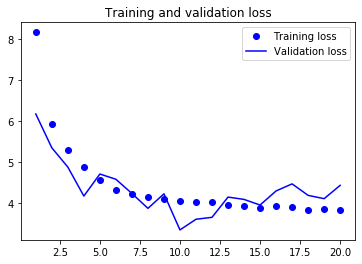

In [78]:
# 결과 그래프
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 뛰는 것 , 과대적합 되는 것을 방지해보았다

## 거꾸로 된 시퀀스를 사용한 LSTM

In [ ]:
from keras.datesets import imdb
from keras.preprocessing import sequence
from keras.layer import Embedding, LSTM, Dense

# 사용할 단어 수
max_features = 10000
# 사용할 텍스트의 길이
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집는다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] fot x in x_test]

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)